Here 2022-01-18 18:20:38


All good


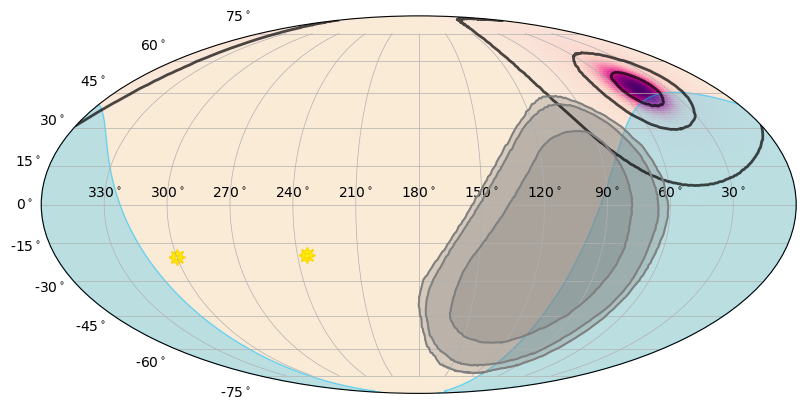

In [1]:
from swift_poshist import SwiftPosHist, SwiftBatPartialCoding
from gbm.plot import SkyPlot
from gbm.plot.gbmplot import SkyPolygon
from gbm.data import GbmHealPix
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from datetime import datetime
import time
from swifttools.swift_too import Swift_ObsQuery
import requests
import wget

class BAT_tools(object):

    def unix2met(self, unixtime):
        """Convert Unix time to Spacecraft time"""
        return int(unixtime) - time.mktime((2001,1,1,0,0,0,0,0,0))+(unixtime-int(unixtime))

    def unix2mjd(self, unixtime):
        """Convert UNIX timestamp into MJD"""
        dt = Time(unixtime,format='unix',scale='utc')
        return dt.mjd

    def get_obsid(self, trigtime_obj):
        timestamp = trigtime_obj
        username = 'sainiris'
        shared_secret = '0cytbonAiHD13G8dFUfC'
        print("Here", timestamp)
        query = Swift_ObsQuery(username, shared_secret, begin=timestamp)
        if query.status.status == 'Accepted':
          print("All good")
        else:
          print(f"Not good: {query.status}")
          return -1,-1,-1
        
        #print("Query is:",query[0])
        obsid = query[0].obsnum
        return obsid


    def justPlot(self,stime, trigid = 0):
        #Time conversions to Met
        #get the attitude file from the identidfied Obsid
        
        #trigtime_obj = datetime.strptime(stime, "%Y-%m-%dT%H:%M:%S")
        #plt.ioff()
        
        trigtime_obj = datetime.strptime(stime, "%Y-%m-%d %H:%M:%S")
        
        unixtime = time.mktime(trigtime_obj.timetuple())

        t0=self.unix2met(unixtime)
 
        obsid = self.get_obsid(trigtime_obj)
        url = f'https://www.swift.ac.uk/archive/reproc/{obsid}/auxil/sw{obsid}sao.fits.gz'
        #wget.download(url)
        saoFile = f'sw{obsid}sao.fits.gz' 
        pos = SwiftPosHist.open(saoFile)
        bat = SwiftBatPartialCoding()
       
        s = SkyPlot()
    
        s.add_poshist(pos, t0, detectors=[],galactic_plane=False)

        #External Localizations
        #if maplike:
        url = 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2021/bn211120548/quicklook/glg_healpix_all_bn211120548.fit'
        skymapfile = download_file(url, cache=True) 
        loc = GbmHealPix.open(skymapfile)
        s.add_healpix(loc,galactic_plane=False,detectors=[])

        bat_rot = bat.rotate(pos.get_quaternions(t0))

        fracs = [0.01,0.1, 0.5]
        polys = []
        for frac in fracs:
          paths = bat_rot.partial_coding_path(frac)
          for path in paths:
            poly = SkyPolygon(path[:,0], path[:,1], s.ax, color='gray', face_alpha=0.3, flipped=True)
            polys.append(poly)
        
        filename = f'{trigid}_skymap.png'
        plt.savefig(filename)       
        return filename        

if __name__ == "__main__":
    p = BAT_tools() 
    p.justPlot("2022-01-18 18:20:38", 1642548038)


